Diabetes Prediction

Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,KFold
import joblib
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

EDA

Read dataset

In [ ]:
df = pd.read_csv('diabetes.csv')

In [ ]:
df.head(5)

In [ ]:
rows , col =  df.shape
print(f"Number of Rows : {rows} \nNumber of Columns : {col}")

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Checking 0 values in the variables

In [ ]:
zero_features = ['Glucose','BloodPressure','SkinThickness',"Insulin",'BMI','DiabetesPedigreeFunction']
total_count = df['Glucose'].count()
for feature in zero_features:
    zero_count = df[df[feature]==0][feature].count()
    print('The number of 0 cases in {0} is {1}, which is {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

As shown above, the ratio of the value of zero in the SkinThickness and Insulin features seems to be high. Let's change the corresponding values to the mean value of each feature.
we will first replace the corresponding value with the mean value.

In [ ]:
from matplotlib import rcParams
feature_names = [cname for cname in df.loc[:,:'Age'].columns]
rcParams['figure.figsize'] = 20,30
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

Distributions of attributes

In [ ]:
from matplotlib import rcParams
feature_names = [cname for cname in df.loc[:,:'Age'].columns]
rcParams['figure.figsize'] = 20,30
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

In [ ]:
diabetes_mean = df[zero_features].mean()
df[zero_features]=df[zero_features].replace(0, diabetes_mean)
zero_features = ['Glucose','BloodPressure','SkinThickness',"Insulin",'BMI','DiabetesPedigreeFunction']
total_count = df['Glucose'].count()
for feature in zero_features:
    zero_count = df[df[feature]==0][feature].count()
    print('The number of 0 cases in {0} is {1}, which is {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

In [ ]:
from matplotlib import rcParams
feature_names = [cname for cname in df.loc[:,:'Age'].columns]
rcParams['figure.figsize'] = 20,30
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

All the 0 values that held no meaning have been replaced.

In [ ]:
sns.pairplot(data = df, hue = 'Outcome' )
plt.show()

Pregnancy and Outcome

In [ ]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(), annot=True, annot_kws={"size": 10}, cbar_kws={"shrink": 0.5})
plt.show()

In [ ]:
hig_corr = df.corr()
hig_corr_features = hig_corr.index[abs(hig_corr["Outcome"]) >= 0.2]
hig_corr_features.drop('Outcome')

Index(['Pregnancies', 'Glucose', 'BMI', 'Age'], dtype='object')

In [ ]:
df.var()

Data Preprocessing

In [ ]:
numeric_columns = ['Insulin', 'DiabetesPedigreeFunction','BMI','Glucose','SkinThickness','BloodPressure']
for column_name in numeric_columns:
    Q1 = np.percentile(df[column_name], 25, interpolation='midpoint')
    Q3 = np.percentile(df[column_name], 75, interpolation='midpoint')
    IQR = Q3 - Q1
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR
    outliers = df[(df[column_name] < low_lim) | (df[column_name] > up_lim)][column_name]
    df[column_name] = np.where(df[column_name] < low_lim, low_lim, df[column_name])
    df[column_name] = np.where(df[column_name] > up_lim, up_lim, df[column_name])

Get input and target columns

In [ ]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [ ]:
colors = ['darkgreen', 'lightgreen']
labels = ['0','1']
values = df['Outcome'].value_counts()/df['Outcome'].shape[0]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Outcome")
fig.show()

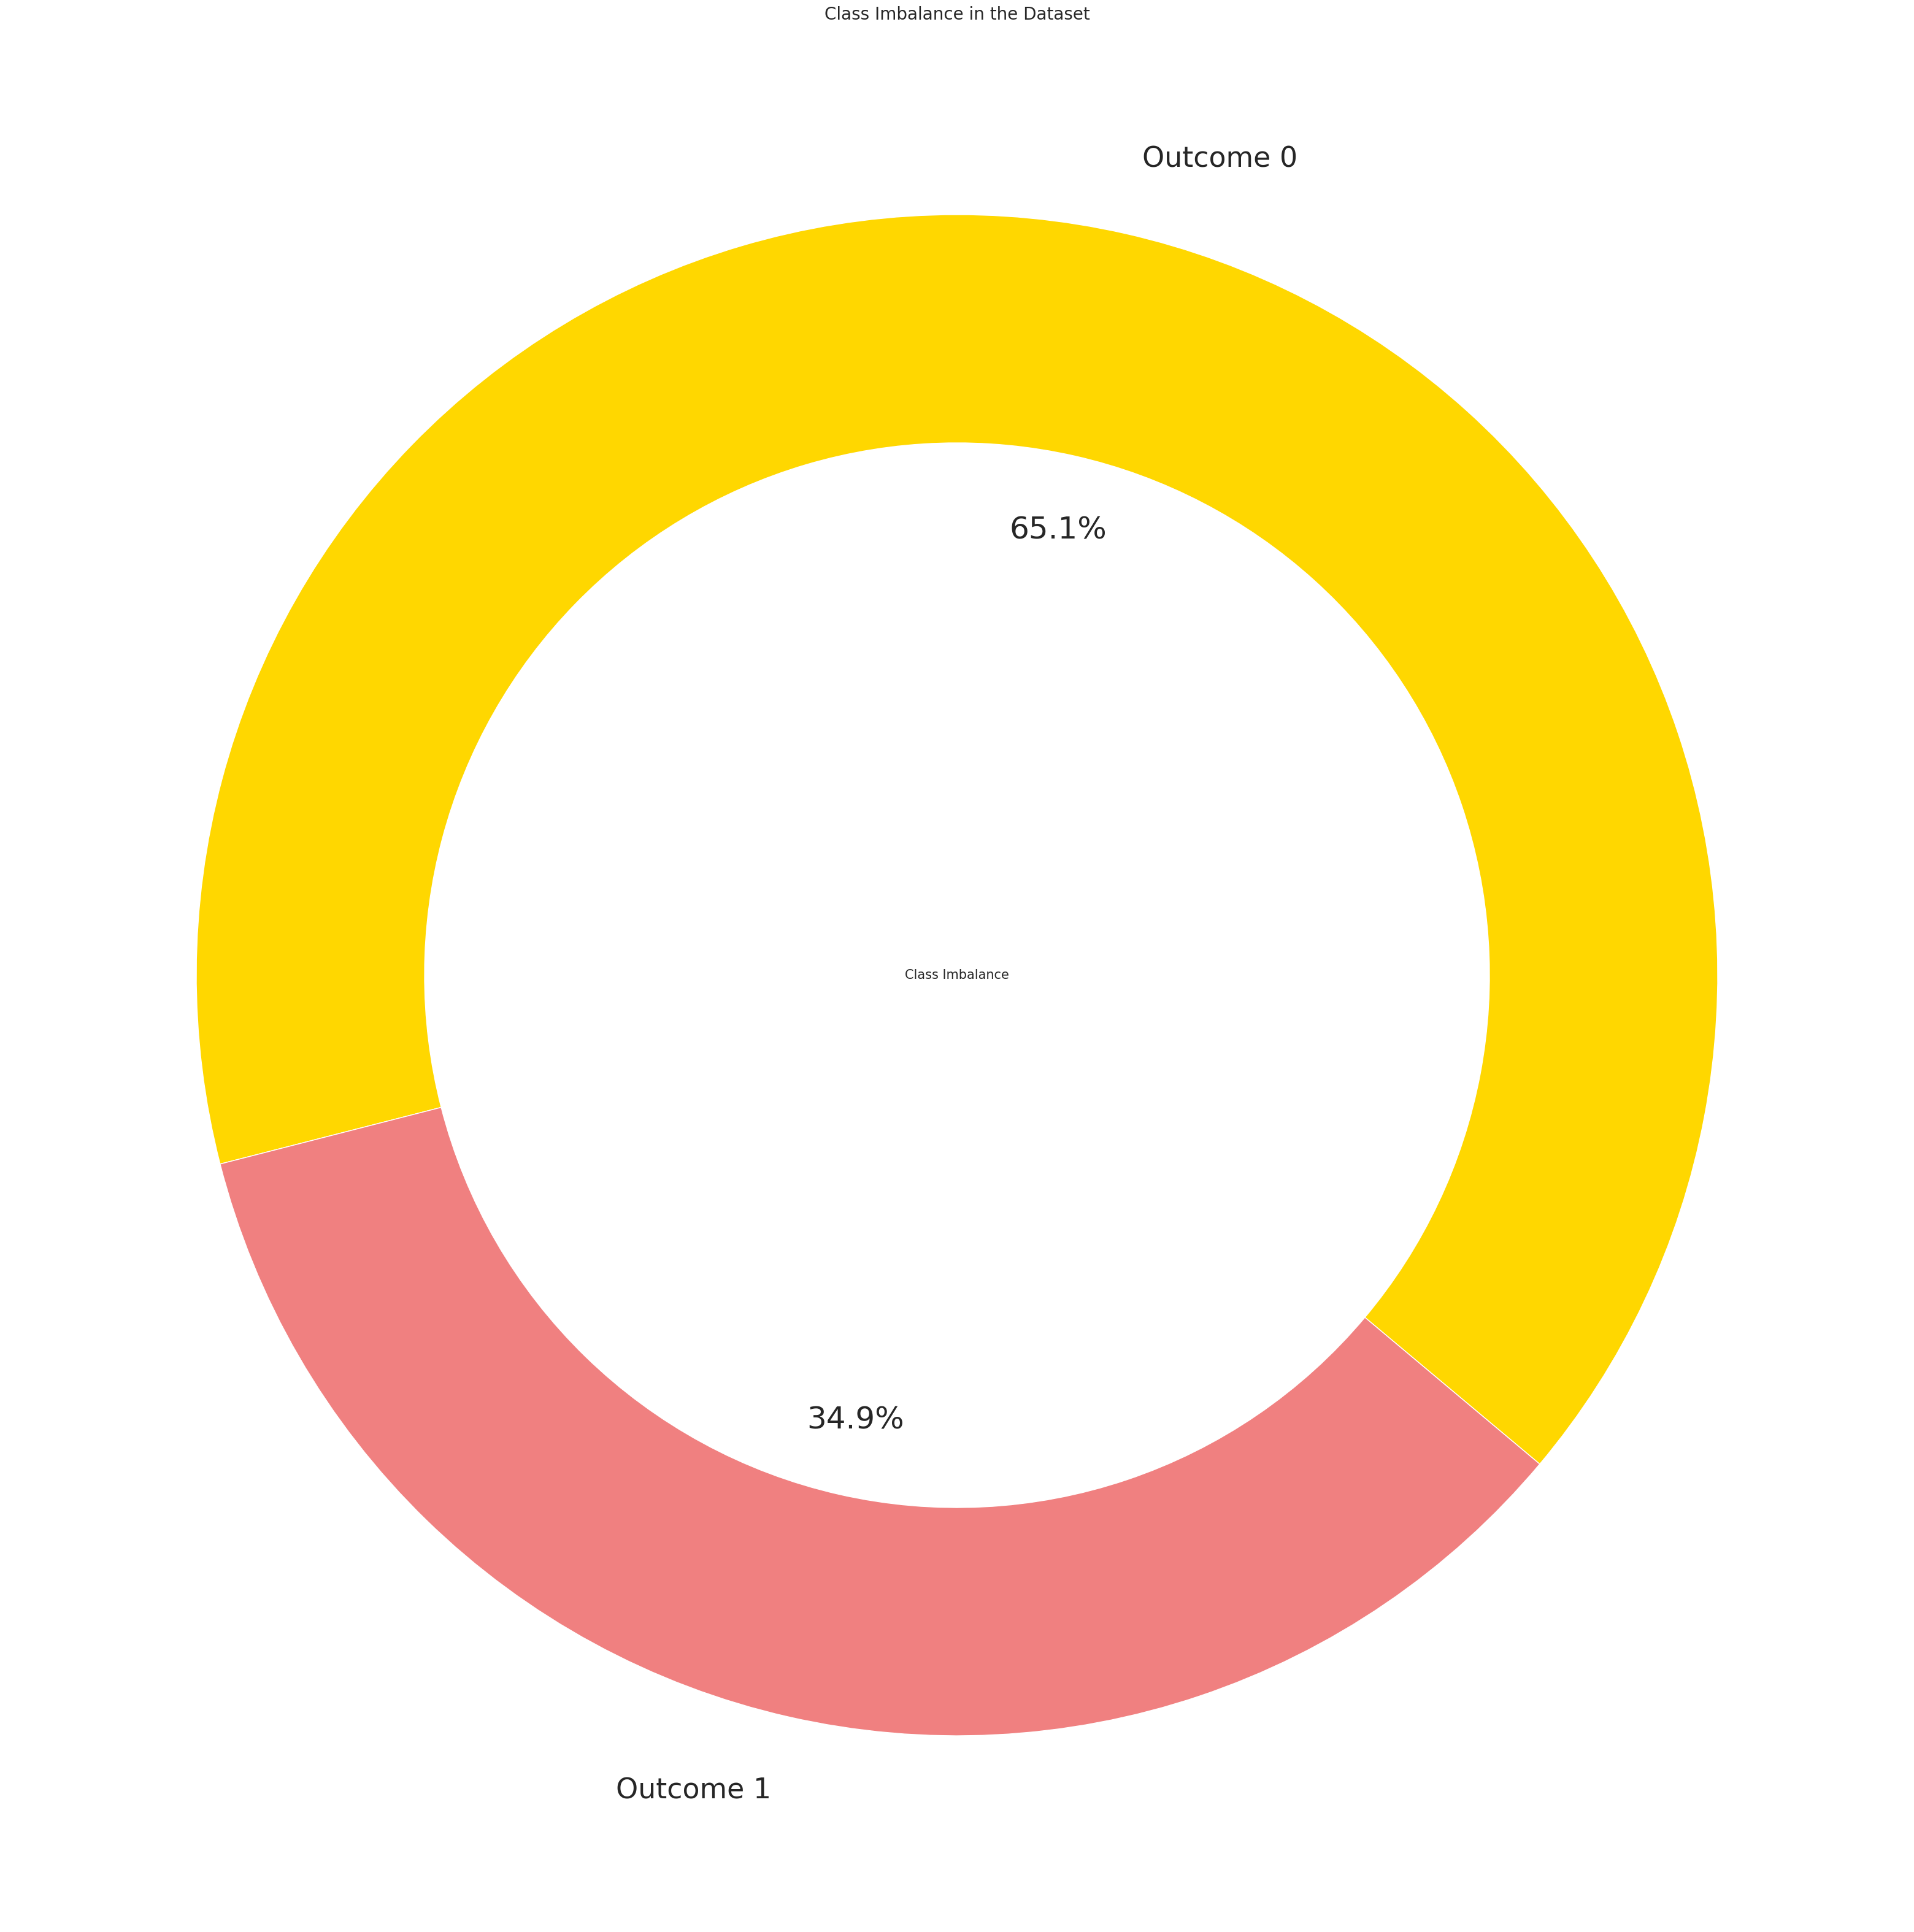

In [ ]:
labels = ['Outcome 0', 'Outcome 1']
sizes = [len(df[df['Outcome'] == 0]), len(df[df['Outcome'] == 1])]
colors = ['gold', 'lightcoral']
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, colors=colors, labels=labels, autopct="%1.1f%%", startangle=-40, wedgeprops=dict(width=0.3))
ax.text(0, 0, "Class Imbalance", fontsize=15, ha='center', va='center')
plt.title("Class Imbalance in the Dataset", fontsize=20)
plt.show()

There is class imbalance, which we shall take care of using oversampling method

In [ ]:
df_majority = df[df['Outcome'] == 0]
df_minority = df[df['Outcome'] == 1]
df_minority_oversampled = resample(df_minority,
                                 replace=True,     # Sample with replacement
                                 n_samples=len(df_majority),  # Match number of samples in majority class
                                 random_state=42)  # Reproducible results
df_oversampled = pd.concat([df_majority, df_minority_oversampled])
X_oversampled = df_oversampled.drop('Outcome', axis=1)
y_oversampled = df_oversampled['Outcome']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_oversampled)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_oversampled, test_size=0.2, random_state=42)

Machine Learning models

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions_log = logmodel.predict(X_test)
print('training accuracy for Logistic Regression = '+str(accuracy_score(y_train,logmodel.predict(X_train))))
print('testing accuracy for Logistic Regression = '+str(accuracy_score(y_test,predictions_log)))
log_reg_train_accuracy_before_tuning = accuracy_score(y_train,logmodel.predict(X_train))
log_reg_test_accuracy_before_tuning = accuracy_score(y_test,predictions_log)

In [ ]:
print(logmodel.get_params())

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Hyper parameter tuning for logistic regression model

In [ ]:
from sklearn.model_selection import GridSearchCV,KFold
param_grid_log = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}
grid_search_log = GridSearchCV(logmodel, param_grid_log, cv=KFold(n_splits=5, shuffle=True, random_state=42))
grid_search_log.fit(X_train, y_train)
best_params_log = grid_search_log.best_params_
print("Best hyperparameters:", best_params_log)
best_model_log = LogisticRegression(**best_params_log)
best_model_log.fit(X_train, y_train)
y_pred = best_model_log.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy for Logistic Tuned:", accuracy)

In [ ]:
predictions_log_tuned_test = best_model_log.predict(X_test)
accuracy_log_tuned_test = accuracy_score(y_test, predictions_log_tuned_test)
accuracy_log_tuned_train = accuracy_score(y_train, best_model_log.predict(X_train))
print("Training accuracy for Logistic Tuned:", accuracy_log_tuned_train)
print("Test accuracy for Logistic Tuned:", accuracy_log_tuned_test)

In [ ]:
log_reg_test_recall_after_tuning = recall_score(y_test, predictions_log_tuned_test)
log_reg_test_precision_after_tuning = precision_score(y_test, predictions_log_tuned_test)
log_reg_test_f1_after_tuning = f1_score(y_test, predictions_log_tuned_test)
log_reg_test_cm_after_tuning = confusion_matrix(y_test, predictions_log_tuned_test)
log_reg_test_auc_roc_after_tuning = roc_auc_score(y_test, predictions_log_tuned_test)
log_reg_test_accuracy_after_tuning = accuracy_score(y_test, predictions_log_tuned_test)
print("Recall for Log Reg After Tuning:", log_reg_test_recall_after_tuning)
print("Precision for Log Reg After Tuning:", log_reg_test_precision_after_tuning)
print("F1-score for Log Reg After Tuning:", log_reg_test_f1_after_tuning)

Random Forest

In [ ]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
predictions_rf = rfc.predict(X_test)
print('training accuracy for Random Forest= '+str(accuracy_score(y_train,rfc.predict(X_train))))
print('testing accuracy for Random Forest= '+str(accuracy_score(y_test,predictions_rf)))

In [ ]:
print(rfc.get_params())

Hyperparameter Tuning of Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV,KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [4, 5, 6, 7, 8],
    'min_samples_split': [5, 10, 15, 100],
    'min_samples_leaf' : [1, 2, 5, 10]
}
grid_rf = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=3,cv = kf)
grid_rf.fit(X_train,y_train)
grid_rf.best_params_
rf_grid_predictions = grid_rf.predict(X_test)
print('training accuracy for tuned Random Forest= '+str(accuracy_score(y_train,grid_rf.predict(X_train))))
print('testing accuracy for tuned Random Forest= '+str(accuracy_score(y_test,rf_grid_predictions)))
grid_rf_test_acc = accuracy_score(y_test,rf_grid_predictions)

In [ ]:
rf_grid_recall = recall_score(y_test, rf_grid_predictions)
rf_grid_precision = precision_score(y_test, rf_grid_predictions)
rf_grid_f1 = f1_score(y_test, rf_grid_predictions)
rf_grid_cm = confusion_matrix(y_test, rf_grid_predictions)
rf_grid_auc_roc = roc_auc_score(y_test, rf_grid_predictions)
print("Recall for RF After Tuning:", rf_grid_recall)
print("Precision for RF After Tuning:", rf_grid_precision)
print("F1-score for RF After Tuning:", rf_grid_f1)

In [ ]:
grid_rf_test_acc = accuracy_score(y_test,rf_grid_predictions)

In [ ]:
grid_rf.get_params()

Decision</b> Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
predictions_tree = dtree.predict(X_test)
print('training accuracy = '+str(accuracy_score(y_train,dtree.predict(X_train))))
print('testing accuracy = '+str(accuracy_score(y_test,predictions_tree)))

In [ ]:
dtree.get_params()

Hyperparameter Tuning Of Decision Tree

In [ ]:
param_grid = {'min_samples_split': range(2, 10),
              'min_samples_leaf': range(1, 10),
              'max_depth': range(2, 10)}
grid_tree = GridSearchCV(DecisionTreeClassifier(),param_grid,refit=True,cv = kf)
grid_tree.fit(X_train,y_train)
grid_tree.best_params_
tree_grid_predictions = grid_tree.predict(X_test)
print('training accuracy for tuned tree= '+str(accuracy_score(y_train,grid_tree.predict(X_train))))
print('testing accuracy for tuned tree= '+str(accuracy_score(y_test,tree_grid_predictions)))

In [ ]:
print(grid_tree.get_params())

In [ ]:
rf_tuned_test_accurcy = accuracy_score(y_test,rf_grid_predictions)

In [ ]:
tree_grid_recall = recall_score(y_test, tree_grid_predictions)
tree_grid_precision = precision_score(y_test, tree_grid_predictions)
tree_grid_f1 = f1_score(y_test, tree_grid_predictions)
tree_grid_cm = confusion_matrix(y_test, tree_grid_predictions)
tree_grid_auc_roc = roc_auc_score(y_test, tree_grid_predictions)
print("Recall for Tree After Tuning:", tree_grid_recall)
print("Precision for Tree After Tuning:", tree_grid_precision)
print("F1-score for Tree After Tuning:", tree_grid_f1)
tree_grid_test_accuracy = accuracy_score(y_test, tree_grid_predictions)
print("Accuracy for Tree After Tuning:", tree_grid_test_accuracy)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
predictions_knn = knn.predict(X_test)
print('training accuracy = '+str(accuracy_score(y_train,knn.predict(X_train))))
print('testing accuracy = '+str(accuracy_score(y_test,predictions_knn)))

In [ ]:
print(knn.get_params())

The model is clearly overfitting

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np
param_grid_knn = {
    'n_neighbors': np.arange(1,21),  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting function for prediction
    'metric': ['euclidean', 'manhattan', 'chebyshev']  # Distance metric
}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=kf)
grid_search_knn.fit(X_train, y_train)
best_params_knn = grid_search_knn.best_params_
print("Best hyperparameters:", best_params_knn)
best_model_knn = KNeighborsClassifier(**best_params_knn)
best_model_knn.fit(X_train, y_train)
y_pred_knn = best_model_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Test accuracy for KNN Tuned:", accuracy_knn)

Training Accuracy of KNN after Tuning =
Testing Accuracy of KNN after Tuning = 0.79

In [ ]:
print('training accuracy for KNN Tuned = '+str(accuracy_score(y_train,grid_search_knn.predict(X_train))))
print('testing accuracy for KNN Tuned = '+str(accuracy_score(y_test,y_pred_knn)))

In [ ]:
knn_grid_recall = recall_score(y_test, y_pred_knn)
knn_grid_precision = precision_score(y_test, y_pred_knn)
knn_grid_f1 = f1_score(y_test, y_pred_knn)
knn_grid_cm = confusion_matrix(y_test, y_pred_knn)
knn_grid_acc = accuracy_score(y_test,y_pred_knn)
knn_grid_auc_roc = roc_auc_score(y_test, y_pred_knn)
print("Recall for KNN After Tuning:", knn_grid_recall)
print("Precision for KNN After Tuning:", knn_grid_precision)
print("F1-score for KNN After Tuning:", knn_grid_f1)
print("Confusion matrix for KNN After Tuning:\n", knn_grid_cm)
print("AUC-ROC score for KNN After Tuning:", knn_grid_auc_roc)
print("Accuracy score for KNN After Tuning:",knn_grid_acc)

The model performance has increased a lot compared to before , and the overfitting is also reduced.

Support Vector </b> Classifier

In [ ]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train, y_train)
predictions_svm= svm_model.predict(X_test)
print('training accuracy = '+str(accuracy_score(y_train,svm_model.predict(X_train))))
print('testing accuracy = '+str(accuracy_score(y_test,predictions_svm)))

In [ ]:
svm_model.get_params()

Hyper parameter tuning for SVM


In [ ]:
param_grid_svm = {
    'C': np.arange(0.1, 5.1, 0.1),
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly']
}
grid_svm = GridSearchCV(SVC(), param_grid_svm, refit=True, cv=kf)
grid_svm.fit(X_train, y_train)
print("Best parameters:", grid_svm.best_params_)
best_model = grid_svm.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Accuracy:", accuracy)

In [ ]:
grid_svm.best_params_
predictions_svm_grid = grid_svm.predict(X_test)
print('training accuracy for SVM tuned = '+str(accuracy_score(y_train,grid_svm.predict(X_train))))
print('testing accuracy for SVM Tuned = '+str(accuracy_score(y_test,predictions_svm_grid)))

Training Accuracy of SVM after tuning = 0.8325
Testing Accuracy of SVM after tuning = 0.79


In [ ]:
grid_svm.best_params_

The performance has increased a lot.

In [ ]:
grid_svm_recall = recall_score(y_test, predictions_svm_grid)
grid_svm_precision = precision_score(y_test, predictions_svm_grid)
grid_svm_f1 = f1_score(y_test, predictions_svm_grid)
grid_svm_cm = confusion_matrix(y_test, predictions_svm_grid)
grid_svm_auc_roc = roc_auc_score(y_test, predictions_svm_grid)
print("Recall for SVM After Tuning:", grid_svm_recall)
print("Precision for SVM After Tuning:", grid_svm_precision)
print("F1-score for SVM After Tuning:", grid_svm_f1)
print("Confusion matrix for SVM After Tuning:\n", grid_svm_cm)
print("AUC-ROC score for SVM After Tuning:", grid_svm_auc_roc)
grid_svm_accuracy = accuracy_score(y_test, predictions_svm_grid)
print("Accuracy for SVM After Tuning:", grid_svm_accuracy)

Deep Learning models</div>

Artificial Neural Network ( ANN )

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
dl_model = Sequential()
dl_model.add(Dense(256,  activation = 'relu' ,input_shape=([8]))) #input layer
dl_model.add(Dense(256,  activation = 'relu'))
dl_model.add(Dense(1,activation = 'sigmoid'))
dl_model.summary()
dl_model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' ,metrics = ['accuracy','AUC'])

In [ ]:
num_epochs = 50
history = dl_model.fit(X_train ,
                       y_train ,
                    epochs= num_epochs ,
                    validation_split=0.2)

dl_model.evaluate(X_test, y_test)
predictions_ann = np.where(dl_model.predict(X_test)>=0.5, 1, 0).reshape(y_test.shape[0])
print('testing accuracy for ANN = '+str(accuracy_score(y_test,predictions_ann)))
accuracy_ann = accuracy_score(y_test,predictions_ann)
print("Training Accuracy of ANN Tuned:", accuracy_score(y_train,(dl_model.predict(X_train)>0.5).astype(int)))
print("Accuracy of ANN Tuned:", accuracy_ann)

Training accuracy before tuning : 0.95875
Testing accuracy before tuning : 0.815


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # Adjust width and height as needed
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy Before Tuning', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [ ]:
params = dl_model.get_config()
params

The accuracy is quite high, let us see if  we can increase it after we perform hyper parameter tuning.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
model_ann_tune = Sequential()
model_ann_tune.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model_ann_tune.add(Dense(128, activation='relu'))
model_ann_tune.add(Dense(1, activation='sigmoid'))
model_ann_tune.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_ann_tune = model_ann_tune.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1, validation_split=0.2, callbacks=[early_stopping])

In [ ]:
predictions_ann_tuned = np.where(model_ann_tune.predict(X_test)>=0.5, 1, 0).reshape(y_test.shape[0])
accuracy_ann_tuned = accuracy_score(y_test,predictions_ann_tuned)
print("Training Accuracy of ANN Tuned:", accuracy_score(y_train,(model_ann_tune.predict(X_train)>0.5).astype(int)))
print("Accuracy of ANN Tuned:", accuracy_ann_tuned)

In [ ]:
model_ann_tune.get_config()

Training accuracy ater tuning : 0.8325
Testing accuracy ater tuning : 0.795


In [ ]:
ann_tuned_recall = recall_score(y_test, predictions_ann_tuned)
ann_tuned_precision = precision_score(y_test, predictions_ann_tuned)
ann_tuned_f1 = f1_score(y_test, predictions_ann_tuned)
ann_tuned_cm = confusion_matrix(y_test, predictions_ann_tuned)
ann_tuned_auc_roc = roc_auc_score(y_test, predictions_ann_tuned)
print("Recall for ANN After Tuning:", ann_tuned_recall)
print("Precision for ANN After Tuning:", ann_tuned_precision)
print("F1-score for ANN After Tuning:", ann_tuned_f1)
print("Confusion matrix for ANN After Tuning:\n", ann_tuned_cm)
print("AUC-ROC score for ANN After Tuning:", ann_tuned_auc_roc)
ann_tuned_accuracy = accuracy_score(y_test, predictions_ann_tuned)
print("Accuracy for ANN After Tuning:", ann_tuned_accuracy)

In [ ]:
plt.figure(figsize=(8, 6))  # Adjust width and height as needed
plt.plot(history_ann_tune.history['accuracy'], label='Training Accuracy')
plt.plot(history_ann_tune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy After Tuning', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [ ]:
import pandas as pd
testing_accuracies = {
    'Logistic Regression': accuracy_log_tuned_test,
    'Decision Tree': tree_grid_test_accuracy,
    'Random Forest': grid_rf_test_acc,
    'KNN': knn_grid_acc,
    'SVM': grid_svm_accuracy,
    'ANN': ann_tuned_accuracy
}
df_testing_accuracies = pd.DataFrame.from_dict(testing_accuracies, orient='index', columns=['Testing Accuracy']).sort_values(by='Testing Accuracy', ascending=False)
styled_df_testing_accuracies = (
    df_testing_accuracies.head(5)
    .style
    .set_properties(**{"background-color": 'white', "color": 'black', "border": "1.5px solid black", 'text-align': 'center'})  # Set background color, text color, and border for the entire DataFrame
    #.set_table_styles([  # Modify the color and background color of the table headers (th)
    #    {"selector": "th", "props": [("color", 'white'), ("background-color", "#333333")]}
    #])
)
styled_df_testing_accuracies